In [1]:
import numpy as np
import pandas as pd
import os
import sys
import math
import matplotlib.pyplot as plot
import datetime
from dss_airflow_utils.hooks import SparkHook
from azure.storage.blob import BlockBlobService
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import prophet
from prophet import Prophet
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)




[2022-08-18 18:35:40,832] {settings.py:174} INFO - settings.configure_orm(): Using pool settings. pool_size=5, pool_recycle=1800, pid=80


In [2]:
import json
import matplotlib.pyplot as plt
import requests
from fred import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# FRED API key is free once user register with account
api_key = 'Please enter your key here'


# CPI Major categroies https://fred.stlouisfed.org/categories/9
# PCE Major categories https://fred.stlouisfed.org/release/tables?rid=54&eid=3220#snid=3211

class FredPy:    
    def __init__(self, token=None):
        self.token = token
        self.url = "https://api.stlouisfed.org/fred/series/observations" + \
                    "?series_id={seriesID}&api_key={key}&file_type=json" + \
                    "&observation_start={start}&observation_end={end}&units={units}"

    def set_token(self, token):
        self.token = token


    def get_series(self, seriesID, start, end, units):

        # The URL string with the values inserted into it
        url_formatted = self.url.format(
            seriesID=seriesID, start=start, end=end, units=units, key=self.token
        )

        response = requests.get(url_formatted)

        if(self.token):
            # If the response was successful, extract the data from it
            if(response.status_code == 200):
                data = pd.DataFrame(response.json()['observations'])[['date', 'value']]\
                        .assign(date = lambda cols: pd.to_datetime(cols['date']))\
                        .assign(value = lambda cols: cols['value'].astype(float))\
                        .rename(columns = {'value': seriesID})

                return data

            else:
                raise Exception("Bad response from API, status code = {}".format(response.status_code))
        else:
            raise Exception("You did not specify an API key.")


 List of Data
 https://data.nasdaq.com/data/FRED-federal-reserve-economic-data/documentation

 History Jan 1950
 Coverage 335,000+ time-series

 GROWTH 
 ---------------------------
 GDP | Gross Domestic Product

 PRICE AND INFLATION
 ---------------------------
 CPI | Consumer Price Index for All Urban Consumers: All Items
 CPILFESL | Consumer Price Index for All Urban Consumers: All Items Less Food & Energy
    
 MONEY SUPPLY
 ---------------------------
 M3 | M3 Money supplies, US

 INTEREST RATE
 ---------------------------
 DFF | Effective Federal Funds Rate

 EMPLOYMENT
 ---------------------------
 UNRATE | Civilian Unemployment Rate
 
 INCOME AND EXPENDITURE
 ---------------------------
 PCE | Personal Consumption Expenditures

 OTHER ECONOMIC INDICATORS
 ---------------------------
 DCOILWTICO | Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma

In [3]:
# Instantiate fredpy object
fredpy = FredPy()
# PCE, PCES, PCEND,GDP,FEDFUNDS

# Set the API key
fredpy.set_token(api_key)

def FRED_Datapull(FRED_ID,ID,start,end,units):

    output = fredpy.get_series(
        seriesID = FRED_ID, 
        start = start,
        end =end,
        units = units
    )
    return output.rename(columns={FRED_ID: ID})

output_CPI = FRED_Datapull('CPIAUCSL','CPI','2018-01-01','2022-06-01','lin')
output_PCEND = FRED_Datapull('PCEND','PCEND','2018-01-01','2022-06-01','lin')
output_M3 = FRED_Datapull('MABMM301USM189S','M3','2018-01-01','2022-06-01','lin')
output_GAS = FRED_Datapull('GASREGM','GAS','2018-01-01','2022-06-01','lin')
output_UNRATE = FRED_Datapull('UNRATE','UNRATE','2018-01-01','2022-06-01','lin')

# output_CPI
# output_PCEND
# output_M3 
# output_GAS
# output_UNRATE

df_merged = pd.DataFrame()
Data_for_forecast = [output_CPI, output_PCEND,output_M3,output_GAS,output_UNRATE]

df_merged  = reduce(lambda  left,right: pd.merge(left,right,on=['date'],how='outer'), Data_for_forecast)
# df_merged  = reduce(lambda  left,right: pd.merge(left,right,on=['date'],how='outer'), Data_for_forecast)
df_merged= df_merged.fillna(method='ffill')
df_merged.tail()
# df_merged.to_csv('df_merged.csv', index = False)

,date,CPI,PCEND,M3,GAS,UNRATE
49,2022-02-01,284.182,3660.0,2.170860e+13,3.517,3.8
50,2022-03-01,287.708,3756.2,2.173990e+13,4.222,3.6
51,2022-04-01,288.663,3732.3,2.165550e+13,4.109,3.6
52,2022-05-01,291.474,3750.2,2.168440e+13,4.444,3.6
53,2022-06-01,295.328,3813.3,2.166750e+13,4.929,3.6


## <span style="color: gray"> Parameter set</span>


In [4]:
# -----------------------------------------
# Input data file
# -----------------------------------------

# df_raw= pd.read_csv("/home/notebook/Time series/demo/sp500 5yr.csv", sep=",", encoding='cp1252')
df_raw=df_merged
# -----------------------------------------
# The number of period to forecast out
# -----------------------------------------
num_period = 6

# -----------------------------------------
#  Frequency of forecast 
#  W=Week, M= Month, D=Daily, MS = Start_of_Month
#  'W-SAT' = weekly, Saturday ending
# -----------------------------------------

# CAT = 'CPIAUCSL'

FREQ = 'MS'

df_merged.tail()


,date,CPI,PCEND,M3,GAS,UNRATE
49,2022-02-01,284.182,3660.0,2.170860e+13,3.517,3.8
50,2022-03-01,287.708,3756.2,2.173990e+13,4.222,3.6
51,2022-04-01,288.663,3732.3,2.165550e+13,4.109,3.6
52,2022-05-01,291.474,3750.2,2.168440e+13,4.444,3.6
53,2022-06-01,295.328,3813.3,2.166750e+13,4.929,3.6


## <span style="color: red"> Warning: ONLY set to 1 when backcast  </span>

NOW Processing:  CPI
[2022-08-18 18:36:08,679] {forecaster.py:924} INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
NOW Processing:  PCEND
[2022-08-18 18:36:11,167] {forecaster.py:924} INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
NOW Processing:  M3
[2022-08-18 18:36:14,055] {forecaster.py:924} INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
NOW Processing:  GAS
[2022-08-18 18:36:16,746] {forecaster.py:924} INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
NOW Processing:  UNRATE
[2022-08-18 18:36:19,836] {forecaster.py:924} INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
CPU times: user 14.3 s, sys: 1.12 s, total: 15.4 s
Wall time: 22.4 s


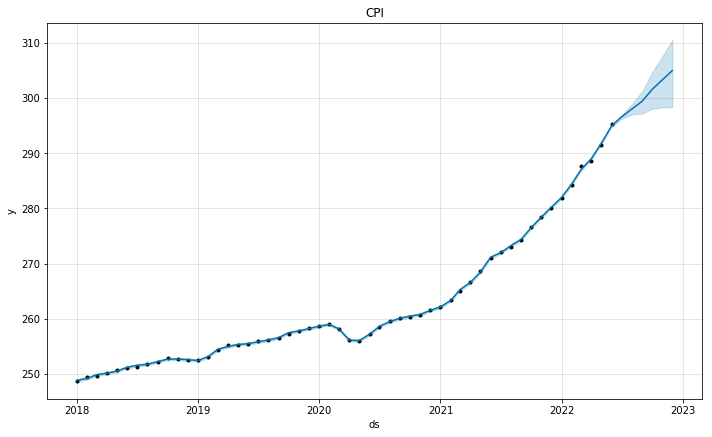

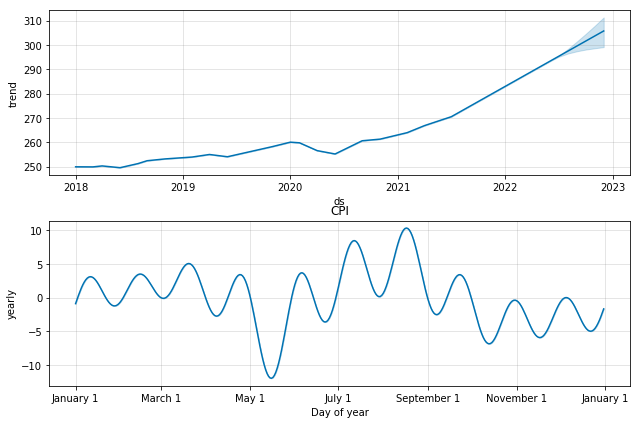

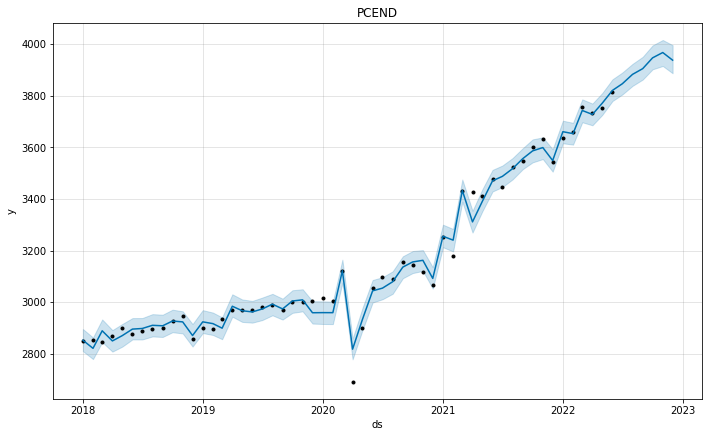

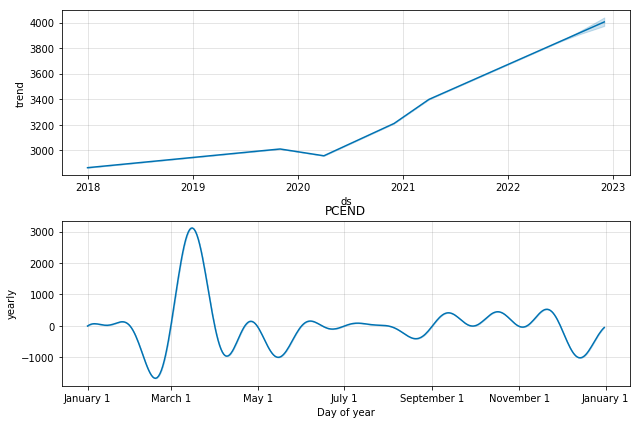

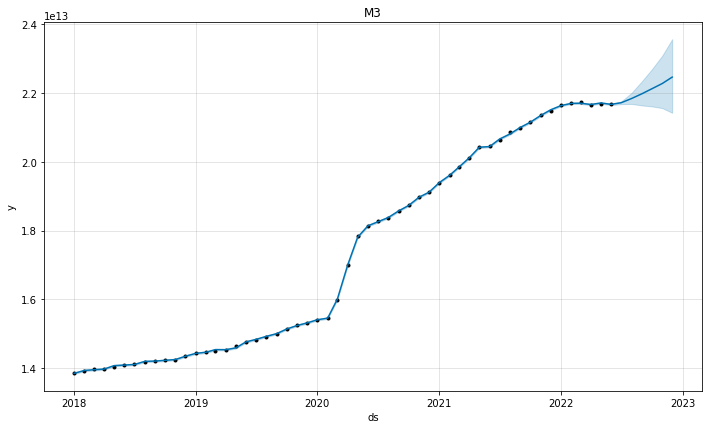

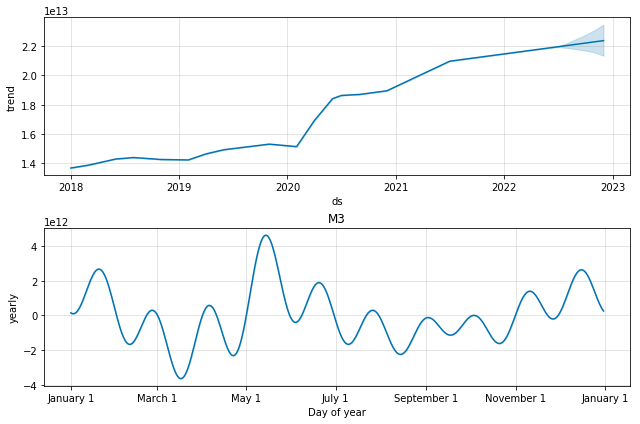

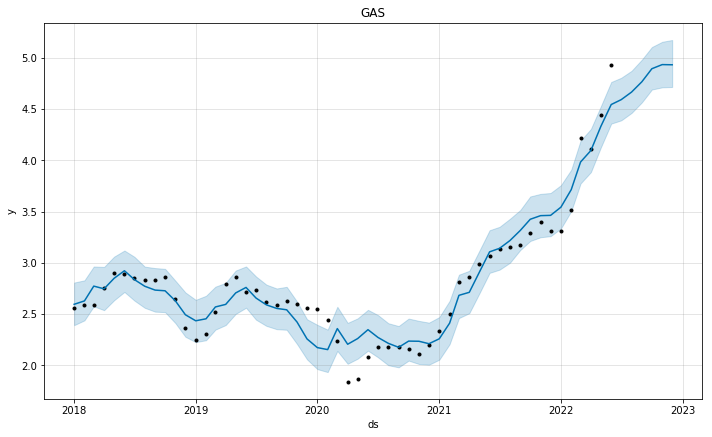

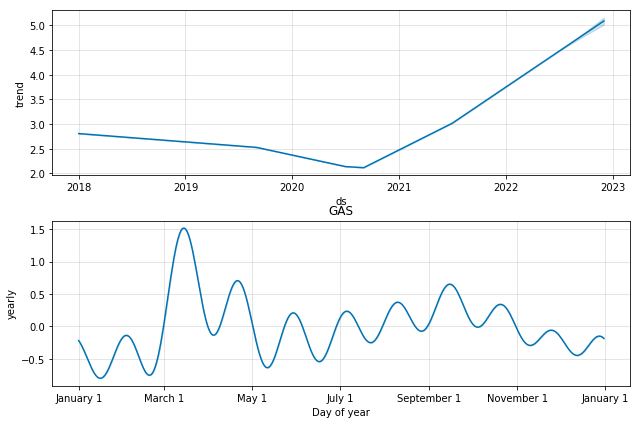

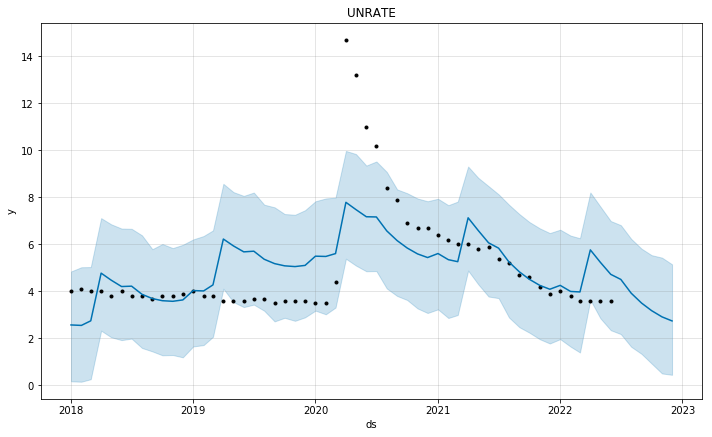

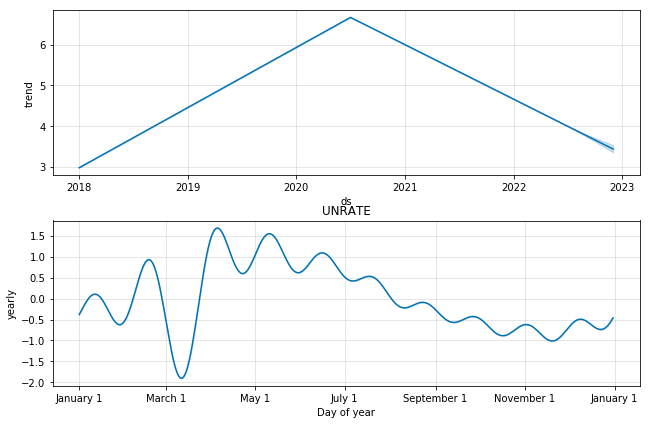

In [5]:
%%time
all_column = list(df_merged.columns) 
all_category  = all_column[1:]
Allcategory = pd.DataFrame()
# print(sub_category)


for CAT in all_category:
    print('NOW Processing: ',CAT)
    df = pd.DataFrame (df_merged, columns =['date',CAT]).reset_index(drop=True)
    df = df.rename(columns = {'date': 'ds', CAT: 'y'}, inplace = False)
    
#     # Python
    m = Prophet(weekly_seasonality=False, changepoint_prior_scale=0.1, seasonality_prior_scale = 0.1)
    m.fit(df)

    future = m.make_future_dataframe(periods=num_period, freq=FREQ,)

    forecast = m.predict(future)

# ----------------------------------------------------------# 
#     Full forecast output with upper / lower bound
# ----------------------------------------------------------# 
    output = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    output1 = output.rename(columns = {'ds':'Time', 'yhat':CAT, 'yhat_lower':CAT+'_lower','yhat_upper':CAT+'_upper'}, inplace = False)
    output_CAT = output1.rename(columns = {'ds':'Time', 'yhat':CAT, 'yhat_lower':CAT+'_lower','yhat_upper':CAT+'_upper'}, inplace = False)
  
# ----------------------------------------------------------# 
#     Forecast output with only the series
# ----------------------------------------------------------#   
    time_lable =  forecast[['ds']]
    time_lable =  time_lable.rename(columns = {'ds':'date'}, inplace = False)
#     output = forecast[['ds', 'yhat']]
#     output_CAT = output.rename(columns = {'ds':'date', 'yhat':CAT}, inplace = False)
    
    fig1 = m.plot(forecast)
    plot.title(CAT)
    fig2 = m.plot_components(forecast)
    plot.title(CAT)
    Allcategory = pd.concat([Allcategory, output_CAT[CAT],output_CAT[CAT+'_lower'],output_CAT[CAT+'_upper']], axis=1).reindex(output_CAT.index)
    Forecast_output = pd.concat([time_lable,Allcategory], axis=1).reindex(Allcategory.index)

In [13]:
Forecast_output_Cut= Forecast_output.tail(num_period)
Forecast_output_Cut.tail()

Final_output = df_merged.append(Forecast_output_Cut, ignore_index=True)
Final_output.to_csv('Forecast_output.csv',index=False)

,date,CPI,CPI_lower,CPI_upper,PCEND,PCEND_lower,PCEND_upper,M3,M3_lower,M3_upper,GAS,GAS_lower,GAS_upper,UNRATE,UNRATE_lower,UNRATE_upper
271,2022-08-01,281.327816,278.139013,284.595831,3629.724211,3549.514376,3719.069719,2.215901e+13,2.166362e+13,2.265580e+13,3.242296,2.726320,3.734138,5.327561,3.610866,7.078088
272,2022-09-01,282.115920,279.297510,285.418985,3646.041962,3564.968078,3730.556164,2.232123e+13,2.184909e+13,2.283635e+13,3.248842,2.755239,3.763091,5.252460,3.651412,6.900033
273,2022-10-01,282.718511,279.641340,286.010959,3661.777312,3577.575011,3745.779413,2.248238e+13,2.202918e+13,2.300225e+13,3.169229,2.665789,3.700344,5.218870,3.617829,6.897920
274,2022-11-01,283.289985,280.199821,286.234098,3676.445044,3590.766307,3766.081264,2.263853e+13,2.216686e+13,2.312873e+13,3.082727,2.552102,3.588739,5.206623,3.601353,7.108391
275,2022-12-01,283.794276,280.689671,286.832645,3678.177656,3597.109273,3765.662996,2.278655e+13,2.225096e+13,2.322474e+13,3.005366,2.497187,3.537964,5.188186,3.502938,6.854411
